---
author: Zeel B Patel
badges: true
categories: ML, GP
description: Multi-class GP classification with different strategies
title: Multi-class classification with Gaussian Processes
date: '2023-07-04'
toc: true
---

In [170]:
import GPy
import numpy as np

from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier, kernels

import matplotlib.pyplot as plt

## Common functions

In [171]:
def get_kernel(ard):
    return GPy.kern.RBF(2, ARD=ard)

def create_and_fit_model(model_class, X, y, ard, **kwargs):
    model = model_class(X, y, get_kernel(ard), **kwargs)
    model.optimize()
    return model

## Generate Synthetic Data

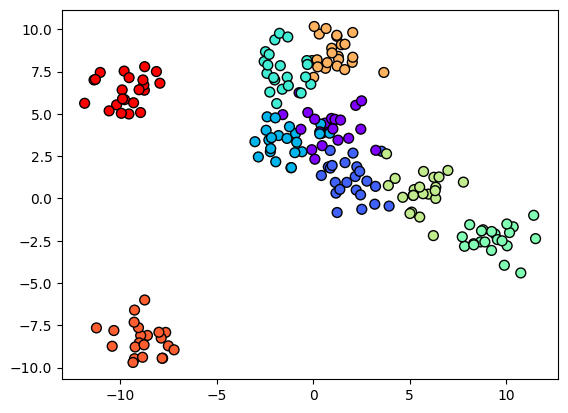

In [172]:
X, y = make_blobs(n_samples=200, centers=9, random_state=0)
# X, y = make_moons(n_samples=200, noise=0.1, random_state=0)
y = y.reshape(-1, 1)
encoder = OneHotEncoder(sparse=False)
encoder.fit(y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow', edgecolor='k');

In [173]:
grid1 = np.linspace(X.min(axis=0)[0]-1, X.max(axis=0)[0]+1, 50)
grid2 = np.linspace(X.min(axis=0)[1]-1, X.max(axis=0)[1]+1, 50)
Grid1, Grid2 = np.meshgrid(grid1, grid2)
X_grid = np.vstack([Grid1.ravel(), Grid2.ravel()]).T

## Train-test split

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
y_train_one_hot = encoder.transform(y_train)
y_test_one_hot = encoder.transform(y_test)

## Treat it as a regression problem

Here we can regress over the class labels as if they are discrete realizations of a continuous variable. We will round the predictions to the nearest integer to get the class labels.

In [175]:
ard_model = create_and_fit_model(GPy.models.GPRegression, X_train, y_train, ard=True)
non_ard_model = create_and_fit_model(GPy.models.GPRegression, X_train, y_train, ard=False)

print("ARD")
preds = ard_model.predict(X_test)[0].round().astype(int)
print(classification_report(y_test, preds))

print("Non-ARD")
preds = non_ard_model.predict(X_test)[0].round().astype(int)
print(classification_report(y_test, preds))

ARD
              precision    recall  f1-score   support

           0       0.67      0.46      0.55        13
           1       0.33      0.57      0.42         7
           2       0.57      0.62      0.59        13
           3       0.71      0.45      0.56        11
           4       0.71      0.91      0.80        11
           5       0.67      0.80      0.73        10
           6       0.33      0.50      0.40         6
           7       0.85      0.65      0.73        17
           8       1.00      0.83      0.91        12

    accuracy                           0.65       100
   macro avg       0.65      0.64      0.63       100
weighted avg       0.69      0.65      0.66       100

Non-ARD
              precision    recall  f1-score   support

           0       0.60      0.46      0.52        13
           1       0.27      0.43      0.33         7
           2       0.57      0.62      0.59        13
           3       0.83      0.45      0.59        11
           4

We get the raw predictions as below:

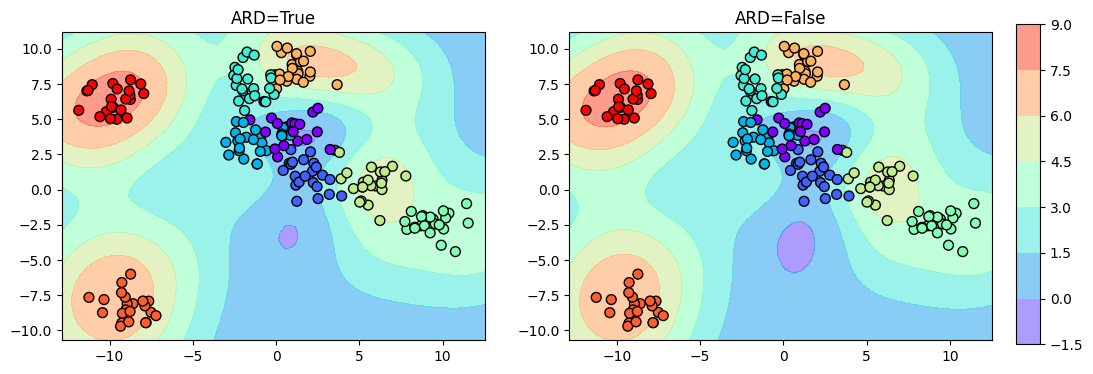

In [176]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax = ax.ravel()
i = 0
mappables = []
for model in [ard_model, non_ard_model]:
    y_grid = model.predict(X_grid)[0]
    mappable = ax[i].contourf(Grid1, Grid2, y_grid.reshape(Grid1.shape), cmap='rainbow', alpha=0.5)
    mappables.append(mappable)
    ax[i].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow', edgecolor='k')
    ax[i].set_title(f"ARD={model.kern.ARD}")
    i += 1

# put a common colorbar for both mappables
fig.colorbar(mappables[0], ax=ax, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]));

Now, let us see the classification boundary:

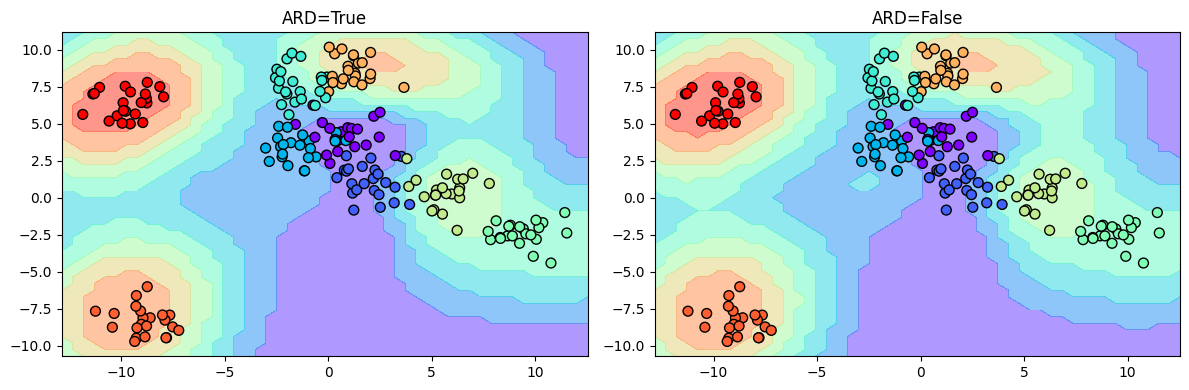

In [177]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax = ax.ravel()
i = 0
for model in [ard_model, non_ard_model]:
    y_grid = model.predict(X_grid)[0].round().astype(int)
    ax[i].contourf(Grid1, Grid2, y_grid.reshape(Grid1.shape), cmap='rainbow', alpha=0.5)
    ax[i].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow', edgecolor='k')
    ax[i].set_title(f"ARD={model.kern.ARD}")
    i += 1

plt.tight_layout()

## Treat it as a multi-output regression problem

In this method, we learn a shared GP model among each class in one v/s rest setting. We can get the predictions by taking the argmax of the predictions from each model.

In [178]:
ard_model = create_and_fit_model(GPy.models.GPRegression, X_train, y_train_one_hot, ard=True)
non_ard_model = create_and_fit_model(GPy.models.GPRegression, X_train, y_train_one_hot, ard=False)

print("ARD")
preds = ard_model.predict(X_test)[0].argmax(axis=1)
print(classification_report(y_test, preds))

print("Non-ARD")
preds = non_ard_model.predict(X_test)[0].argmax(axis=1)
print(classification_report(y_test, preds))

ARD
              precision    recall  f1-score   support

           0       0.80      0.62      0.70        13
           1       0.67      0.86      0.75         7
           2       0.85      0.85      0.85        13
           3       0.92      1.00      0.96        11
           4       1.00      1.00      1.00        11
           5       0.90      0.90      0.90        10
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00        17
           8       1.00      1.00      1.00        12

    accuracy                           0.91       100
   macro avg       0.90      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100

Non-ARD
              precision    recall  f1-score   support

           0       0.80      0.62      0.70        13
           1       0.67      0.86      0.75         7
           2       0.85      0.85      0.85        13
           3       0.92      1.00      0.96        11
           4

What will happen if we ignore the points where the predictions are below 0.5?

In [179]:
print("ARD")
pred_probas = ard_model.predict(X_test)[0]
pred_proba = pred_probas.max(axis=1)

mask = pred_proba > 0.5
preds = ard_model.predict(X_test)[0].argmax(axis=1)
preds_masked = preds[mask]
ground_truth_masked = y_test[mask]

print(ground_truth_masked.shape, preds_masked.shape)
print(classification_report(ground_truth_masked, preds_masked))

ARD
(98, 1) (98,)
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.67      0.86      0.75         7
           2       0.92      0.85      0.88        13
           3       0.92      1.00      0.96        11
           4       1.00      1.00      1.00        11
           5       0.90      0.90      0.90        10
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00        17
           8       1.00      1.00      1.00        12

    accuracy                           0.92        98
   macro avg       0.91      0.92      0.91        98
weighted avg       0.92      0.92      0.92        98



Let's visualize the uncertain points:

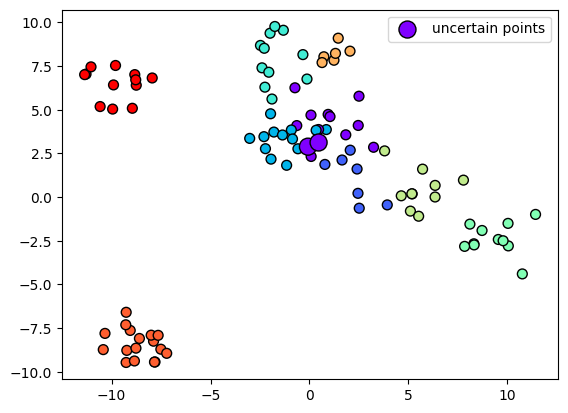

In [180]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap='rainbow', edgecolor='k')
plt.scatter(X_test[~mask, 0], X_test[~mask, 1], s=150, c=y_test[~mask], cmap='rainbow', edgecolor='k', label='uncertain points');
plt.legend();

We see that some points close to the decision boundary are uncertain. We can now plot the decision boundary:

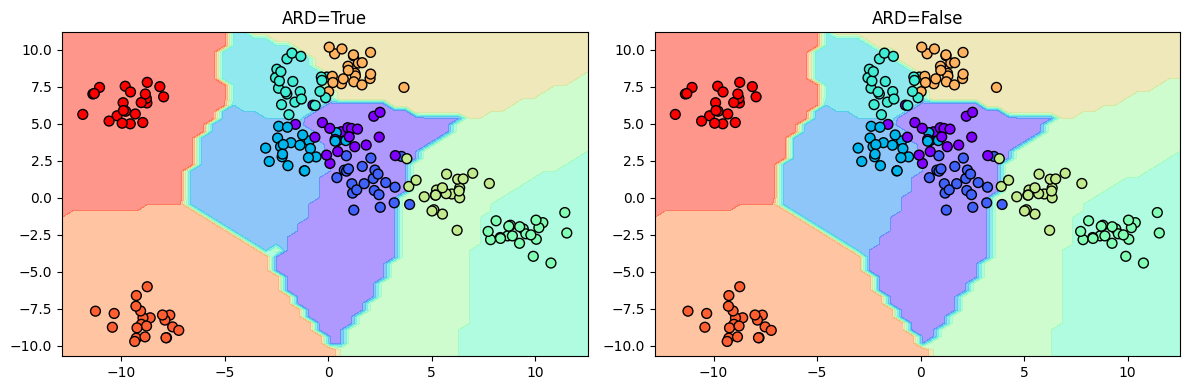

In [181]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax = ax.ravel()
i = 0
for model in [ard_model, non_ard_model]:
    y_grid = model.predict(X_grid)[0].argmax(axis=1)
    ax[i].contourf(Grid1, Grid2, y_grid.reshape(Grid1.shape), cmap='rainbow', alpha=0.5)
    ax[i].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow', edgecolor='k')
    ax[i].set_title(f"ARD={model.kern.ARD}")
    i += 1

plt.tight_layout()

## Treat it as a One v/s Rest classification problem

Here we learn a separate model for each class. We can get the predictions by taking the argmax of the predictions from each model.

In [186]:
ard_kernel = kernels.ConstantKernel() * kernels.RBF(length_scale=[0.01, 0.01])
# non_ard_kernel = kernels.ConstantKernel() * kernels.RBF(length_scale=0.1)
ard_model = GaussianProcessClassifier(kernel=ard_kernel, random_state=0)
# non_ard_model = GaussianProcessClassifier(kernel=non_ard_kernel, random_state=0)
ard_model.fit(X_train, y_train.ravel())
# non_ard_model.fit(X_train, y_train.ravel())

print("ARD")
preds = ard_model.predict(X_test)
print(classification_report(y_test, preds))
# print("Non-ARD")
# preds = non_ard_model.predict(X_test)
# print(classification_report(y_test, preds))

ARD
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.00      0.00      0.00         7
           2       1.00      0.08      0.14        13
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00        17
           8       0.12      1.00      0.22        12

    accuracy                           0.13       100
   macro avg       0.12      0.12      0.04       100
weighted avg       0.14      0.13      0.04       100



 /home/patel_zeel/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 /home/patel_zeel/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 /home/patel_zeel/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Visualizing the decision boundary:

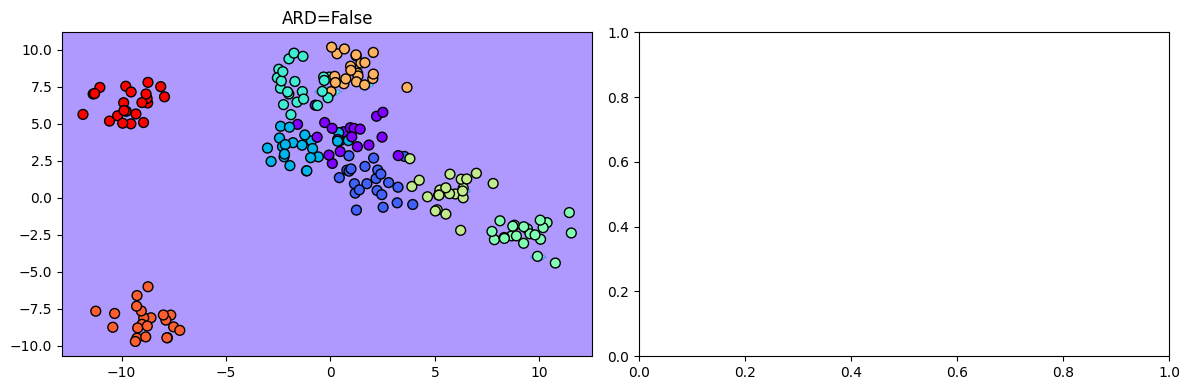

In [188]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax = ax.ravel()
i = 0
for model in [ard_model]:
    y_grid = model.predict_proba(X_grid).argmax(axis=1)
    ax[i].contourf(Grid1, Grid2, y_grid.reshape(Grid1.shape), cmap='rainbow', alpha=0.5)
    ax[i].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow', edgecolor='k')
    ax[i].set_title(f"ARD={bool(i)}")
    i += 1

plt.tight_layout()